In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import os, glob
import matplotlib.pyplot as plt

In [47]:
from skimage.util import img_as_float
from PIL import Image
from skimage import io
from scipy.signal import convolve2d
from skimage import color, data, restoration
from matplotlib.pyplot import matplotlib
from sklearn import datasets
from sklearn import decomposition
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings("ignore")

In [10]:
#Principle Feature Analysis
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [ ]:
#histogram function for comparing a feature across conditions
#input: dataframe, feature of interest
def hist(cells, feature):
    x1 =cells[cells.index.get_level_values('Metadata_PositionY')==(2)]
    x2 = cells[cells.index.get_level_values('Metadata_PositionY')==(3)]
    x3 = cells[cells.index.get_level_values('Metadata_PositionY')==(4)]
    x4 =cells[cells.index.get_level_values('Metadata_PositionY')==(5)]
    x5 =cells[cells.index.get_level_values('Metadata_PositionY')==(6)]
    kwargs = dict(alpha=0.7, bins=100,density=True, stacked=True)

    plt.hist(x1[feature], **kwargs, color='r', label='control')
    plt.hist(x2[feature], **kwargs, color='b', label='DMSO')
    plt.hist(x3[feature], **kwargs, color='y', label='ROCK')
    plt.hist(x4[feature], **kwargs, color='black', label='CHIR')
    plt.hist(x5[feature], **kwargs, color='g', label='IWP')
    plt.gca().set(title='Frequency Histogram of Area', ylabel='Frequency')
    plt.xlim(0,4000)
    plt.legend();

In [11]:
#extract files and convert to combined pandas df
path = "C:/Users/xinli/Desktop/Work/Spreadsheets/features2"
files = glob.glob(os.path.join(path,  "*Cells.csv"))
cells = pd.concat((pd.read_csv(f) for f in files))

In [12]:
#convert metadata to index columns
cells['Metadata_PY']=cells['Metadata_PositionY']
cells=cells.set_index(['Metadata_PositionX', 'Metadata_PositionY','ObjectNumber','Metadata_Site'])
encoder = LabelEncoder()

In [13]:
#normalize data
for col in cells:
    if col != 'Metadata_PY':
        cells[col] = encoder.fit_transform(cells[col])
x_features = cells.iloc[:,10:1384]
x_features.dropna()
x_features.fillna(x_features.mean())
y_label = cells.iloc[:,7]

scaler = StandardScaler()
x_features = scaler.fit_transform(x_features)

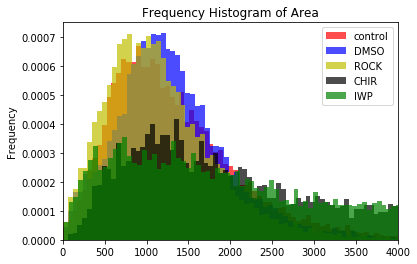

In [14]:
#histogram function
hist(cells, 'AreaShape_Area')

In [15]:
#PFA 
pfa = PFA(n_features=10)
pfa.fit(cells)
features = pfa.features_
column_indices = pfa.indices_

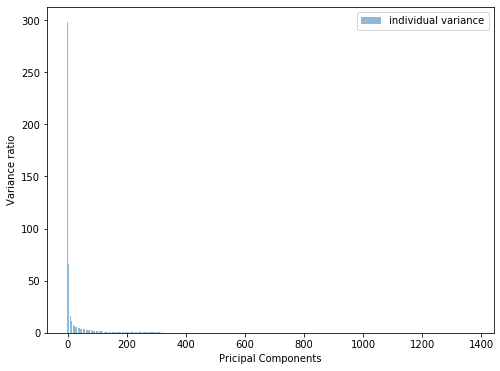

In [16]:
#PCA
pca = PCA()
pca.fit_transform(x_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8,6))
plt.bar(range(1374), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Pricipal Components')
plt.show()

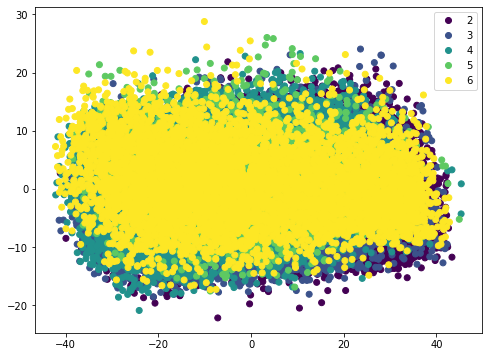

In [18]:
pca2 = PCA(n_components=200)
pca2.fit_transform(x_features)
x_3d = pca2.fit_transform(x_features)

        
plt.figure(figsize=(8,6))
scatter=plt.scatter(x_3d[:,0], x_3d[:,5], c= cells['Metadata_PY'])
labels = np.unique(cells['Metadata_PY'])
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
plt.legend(handles, labels)
plt.show()

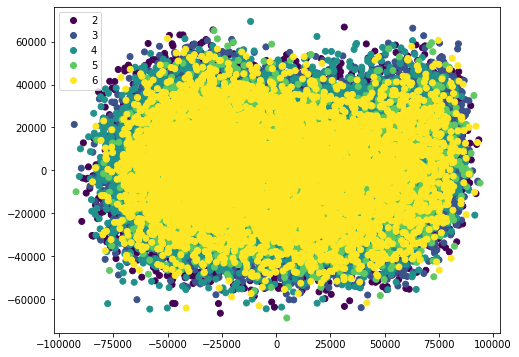

In [25]:
df2 = cells.filter(regex='AreaShape')
pca2 = PCA(n_components=10)
pca2.fit_transform(df2)
df2 = pca2.fit_transform(df2)

        
plt.figure(figsize=(8,6))
scatter=plt.scatter(df2[:,0], df2[:,5], c= cells['Metadata_PY'])
labels = np.unique(cells['Metadata_PY'])
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
plt.legend(handles, labels)
plt.show()

In [ ]:
pca3 = PCA(n_components=2)
principalC = pca3.fit_transfrom(x_features)
principalDF = pd.DataFrame()(data=principalC)

cells2 = pd.DataFrame(cells, columns = cells.columns)

data_scaled = pd.DataFrame(preprocessing.scale(cells2), columns = cells2.columns)
pca3 = PCA(n_components = 5)
pca3.fit_transform(data_scaled)
x = pd.DataFrame(pca3.components_,columns = data_scaled.columns, index=['PC-1','PC-2','pc3','pc4','pc5'])
x = x.transpose()
x = x.sort_values(by=['PC-1'], ascending = False)

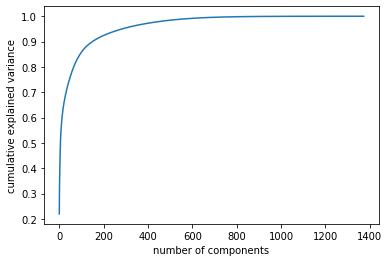

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
DMSO=cells[cells['Metadata_PY']==3]
control=cells[cells['Metadata_PY']==4]

In [31]:
numeric_cols = cells.select_dtypes(include=[np.number]).columns
z_scores=cells[numeric_cols].apply(zscore)
z_scores.drop(z_scores.columns[[0,1,2,3,4,5,6]], axis=1)
z_scores.insert(0,"Condition", cells['Metadata_PY'],True)
z_scores.std(axis=0,skipna=True)
z_scores.mean(axis=0, skipna=True)

met= cells['Metadata_PY']
sum = z_scores.sum(axis=1)
abs =((z_scores.abs()).sum(axis=1))
combined=pd.concat([sum, abs,cells['Metadata_PY']], axis=1,verify_integrity=True)
combined.columns = ['sum', 'absolute sum','Condition']
less= combined[combined['sum']<-50]

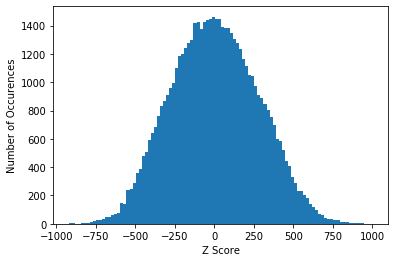

In [32]:
plt.hist(sum, bins = 100)
plt.xlabel('Z Score')
plt.ylabel('Number of Occurences')
plt.show()

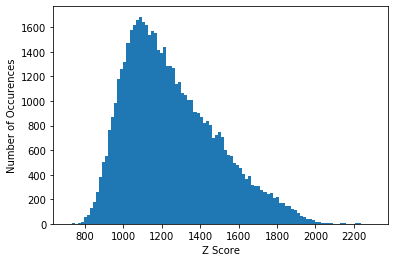

In [33]:
plt.hist(abs, bins = 100)
plt.xlabel('Z Score')
plt.ylabel('Number of Occurences')
plt.show()

In [34]:
#Create df with only Shape and Intensity Features
cells2=pd.DataFrame(data=cells)
cellsAS=cells2.filter(regex=('^AreaShape'),axis=1)
cellsI=cells2.filter(regex=('^Intensity'),axis=1)
cells2 = pd.concat([cellsAS, cellsI], axis=1)
encoder = LabelEncoder()

In [35]:
#normalize data
x_features = cells2.iloc[:,10:124]
x_features.dropna()
x_features.fillna(x_features.mean())
y_label = cells.iloc[:,7]

scaler = StandardScaler()
x_features = scaler.fit_transform(x_features)

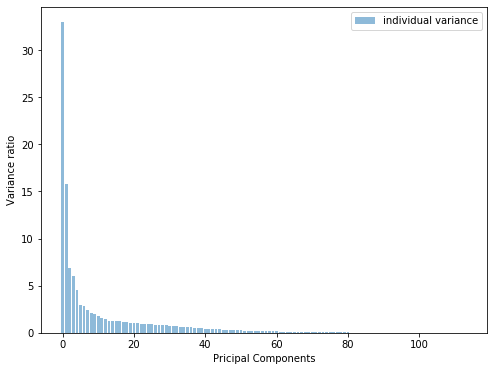

In [36]:
#PCA
pca = PCA()
pca.fit_transform(x_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8,6))
plt.bar(range(114), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Pricipal Components')
plt.show()

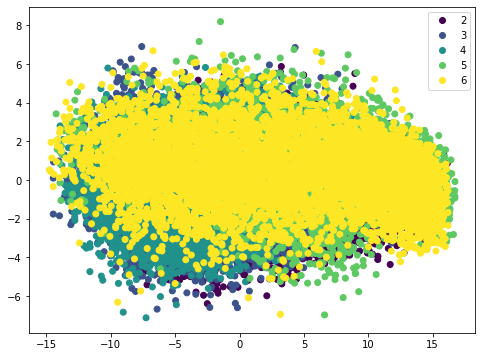

In [38]:
pca2 = PCA(n_components=20)
pca2.fit_transform(x_features)
x_3d = pca2.fit_transform(x_features)

        
plt.figure(figsize=(8,6))
scatter=plt.scatter(x_3d[:,0], x_3d[:,5], c= cells['Metadata_PY'])
labels = np.unique(cells['Metadata_PY'])
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
plt.legend(handles, labels)
plt.show()

In [ ]:
img5 = io.imread('C:/Users/xinli/Desktop/Work/Photos/E10/iPSC-WiCell-CellPainting_E10_s10_w2.TIFF')
img5 = img_as_float(img5)
psf = np.ones((5,5)) / 25
img6 = convolve2d(img5,psf,'same')
img6 += 0.1 * img6.std() * np.random.standard_normal(img6.shape)
Wiener_filtered = restoration.wiener(img6,psf,1100)

In [ ]:
img = Image.fromarray(Wiener_filtered, 'L')
img.save('my.png')
img.show()
img = Image.fromarray(img5, 'P')